231
           0        1      2      3      4      5        6         7      8  \
0      8.693    1.164  0.131  0.000  0.049  0.000    0.243    69.779  0.106   
1     22.395   32.202  0.427  0.000  0.053  0.104    0.392    27.550  0.141   
2     50.843   58.076  2.438  0.000  0.253  0.000    0.418  1666.335  0.291   
3     66.151   29.167  0.103  0.000  0.086  0.142  332.090    18.384  0.105   
4     54.679   52.251  0.492  0.024  0.042  0.083    0.367  2286.112  0.061   
..       ...      ...    ...    ...    ...    ...      ...       ...    ...   
226   78.057   18.612  2.117  0.242  0.060  0.090    0.542    21.353  0.073   
227  307.665   84.385  6.185  1.029  0.257  0.661    0.274    19.099  0.624   
228  224.079  112.152  7.181  0.084  0.440  0.000    0.853     4.641  0.748   
229    8.973    0.574  0.000  0.000  0.075  0.147    0.891    37.523  0.036   
230   52.029   10.074  4.695  0.187  0.000  0.646    0.264    10.163  0.317   

         9  ...    419    420    421    422    

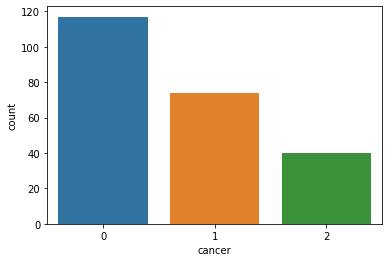

In [107]:
import logging
import math
import pandas as pd
import numpy as np
from scipy.interpolate import UnivariateSpline
from matplotlib import pyplot as plt
from scipy.stats import rankdata
from sklearn.preprocessing import normalize
from math import log
from mpl_toolkits.axes_grid1 import make_axes_locatable   
import random
from mpl_toolkits.mplot3d import axes3d

from scipy.special import logit as logit
import seaborn as sns
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

clinical_231_file = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\clinical_231_data.csv'
mRNA_231_file = 'C:\\Users\\bird\\Desktop\\cancer_project_github\\cancer_data\\data_mRNA_231_sort_with_sensitive.csv'
filterd_data = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\filtered_428_genes_data.csv'

df = pd.read_csv(filterd_data)
df = df.drop(columns = ['Hugo_ID'])
cancer_types =  [0]*117+[1]*74+[2]*40
print(len(cancer_types))
# sns.countplot(x = 'Hugo_ID', data=df)
df = df.T

df['cancer'] = cancer_types
print(df)

sns.countplot(x = 'cancer', data=df)


In [16]:
print(len(X_train[0]))

133


Train set datapoints: 207
Validation set datapoints: 24


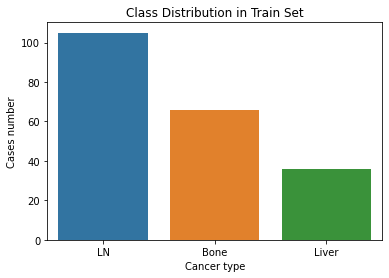

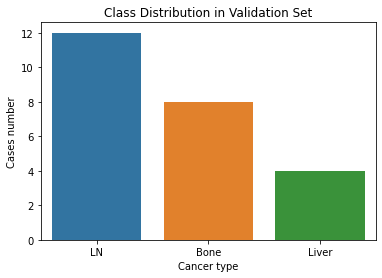

In [108]:
class2idx = {
    0:0,
    1:1,
    2:2
}

idx2class = {v: k for k, v in class2idx.items()}

df['cancer'].replace(class2idx, inplace=True)

X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=21)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
print("Train set datapoints: "+str(len(X_train)))
print("Validation set datapoints: "+str(len(X_val)))

def get_class_distribution(obj):
    count_dict = {
        "LN": 0,
        "Bone": 0,
        "Liver": 0
    }
    
    for i in obj:
        if i == 0: 
            count_dict['LN'] += 1
        elif i == 1: 
            count_dict['Bone'] += 1
        elif i == 2: 
            count_dict['Liver'] += 1          
        else:
            print("Check classes.")
            
    return count_dict



ax = sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(),\
            x = "variable", y="value")
ax.set(xlabel="Cancer type", ylabel = "Cases number", title="Class Distribution in Train Set")
plt.show(ax)
ax2 = sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), \
            x = "variable", y="value")
ax2.set(xlabel="Cancer type", ylabel = "Cases number",title="Class Distribution in Validation Set")
plt.show(ax2)

0
1
0


In [109]:
# custom Dataset
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())

#Weighted Sampling
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)


class_weights_all = class_weights[target_list]
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

tensor([0.0095, 0.0152, 0.0278])


In [110]:
EPOCHS = 200
BATCH_SIZE = len(X_train[0])
LEARNING_RATE = 0.0001
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 3


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)

class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)


MulticlassClassification(
  (layer_1): Linear(in_features=428, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [16]:
# 

In [111]:

def multi_acc(y_pred, y_test, ind):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
#     print(y_pred_tags)
#     if(ind!=-1 and y_pred_tags != y_test):
#         print(ind)
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch, -1)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        ind = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch,ind)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            ind+=1
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    if e%10 == 0:
        print(f'Epoch {e}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')


Begin training.


Epoch 10: | Train Loss: 0.83000 | Val Loss: 1.07393 | Train Acc: 100.000| Val Acc: 54.167
Epoch 20: | Train Loss: 0.62713 | Val Loss: 0.98808 | Train Acc: 100.000| Val Acc: 79.167
Epoch 30: | Train Loss: 0.51750 | Val Loss: 0.84559 | Train Acc: 100.000| Val Acc: 83.333
Epoch 40: | Train Loss: 0.43989 | Val Loss: 0.68741 | Train Acc: 100.000| Val Acc: 83.333
Epoch 50: | Train Loss: 0.36621 | Val Loss: 0.58214 | Train Acc: 100.000| Val Acc: 83.333
Epoch 60: | Train Loss: 0.34911 | Val Loss: 0.52845 | Train Acc: 100.000| Val Acc: 83.333
Epoch 70: | Train Loss: 0.27155 | Val Loss: 0.49676 | Train Acc: 100.000| Val Acc: 87.500
Epoch 80: | Train Loss: 0.24663 | Val Loss: 0.48166 | Train Acc: 100.000| Val Acc: 87.500
Epoch 90: | Train Loss: 0.23433 | Val Loss: 0.47314 | Train Acc: 100.000| Val Acc: 83.333
Epoch 100: | Train Loss: 0.24458 | Val Loss: 0.47984 | Train Acc: 100.000| Val Acc: 83.333
Epoch 110: | Train Loss: 0.19407 | Val Loss: 0.48334 | Train Acc: 100.000| Val Acc: 83.333
Epoch 12

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

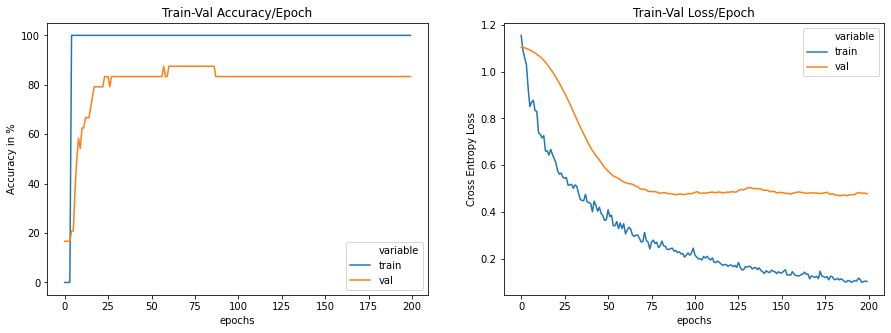

In [112]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"}).rename(columns={"value":"Accuracy in %"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"}).rename(columns={"value":"Cross Entropy Loss"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="Accuracy in %", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="Cross Entropy Loss", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

# ax = sns.lineplot(data=train_val_loss_df, x = "epochs", y="value")
# plt.show(ax)

              precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       0.78      0.88      0.82         8
           2       0.75      0.75      0.75         4

    accuracy                           0.83        24
   macro avg       0.81      0.82      0.81        24
weighted avg       0.84      0.83      0.83        24



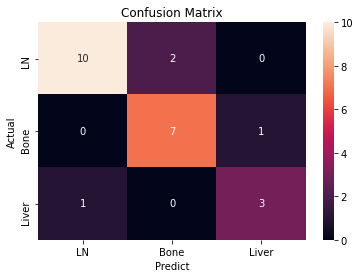

In [113]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in val_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

class2idx = {
    'LN':0,
    'Bone':1,
    'Liver':2
}

idx2class = {v: k for k, v in class2idx.items()}
# print(idx2class)
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_val, y_pred_list)).rename(columns=idx2class, index=idx2class)

sns.heatmap(confusion_matrix_df, annot=True).set(xlabel="Predict", ylabel = "Actual",title="Confusion Matrix")
print(classification_report(y_val, y_pred_list))

In [2]:
"""
load data
"""
# filterd_data = mRNA_231_file
# the SAMPLE_ID in the file is the corresponding SAMPLE_ID in data_mRNA_231_sort_with_sensitive
mRNA_231_df=pd.read_csv(filterd_data)

st = [str(x) for x in range(231)]

mRNA_231_df.drop_duplicates(subset=st)

mRNA_231_df = mRNA_231_df.set_index('SAMPLE_ID')
print(mRNA_231_df)

               0       1       2       3       4          5       6        7  \
SAMPLE_ID                                                                      
2          8.693  22.395  50.843  66.151  54.679  11564.212  43.055  394.181   
9          1.164  32.202  58.076  29.167  52.251   8333.306  18.559  101.457   
33         0.131   0.427   2.438   0.103   0.492     33.970   0.000    3.231   
48         0.000   0.000   0.000   0.000   0.024      2.236   0.028    0.147   
79         0.049   0.053   0.253   0.086   0.042      0.252   0.000    0.171   
...          ...     ...     ...     ...     ...        ...     ...      ...   
13864      0.012   0.081   0.000   0.000   0.005      0.032   0.006    0.000   
13874      0.018   0.013   0.000   0.051   0.000      0.032   0.000    0.000   
13940      0.016   0.044   0.032   1.883   0.007      0.000   0.000    0.022   
14010      0.000   0.000   0.000   0.152   0.008      0.000   0.000    0.008   
14119      0.006   0.021   0.025   0.011

In [4]:
mRNA_231_df=pd.read_csv(filterd_data)
mRNA_231_df = mRNA_231_df.set_index('SAMPLE_ID')
patient_mRNA = []
for column in mRNA_231_df:
    #     print(mRNA_244_df[column].tolist())
    patient_mRNA.append(mRNA_231_df[column].tolist())
mRNA_np = np.asarray(patient_mRNA)



print(mRNA_np.shape)
    


sorts = {"":'0',
    "homo":'1',
    "hetero":"2"}

norms = {'': '0',
         'linear_scale_and_bin': 'A',
         'log_scale_and_bin': 'A',
         'rank_and_scale': 'B'
}

params = ['homo','mean', 'rank_and_scale', sorts, norms] # scheme = {'', 'hetero' 'homo'}, norm = {'','rank_and_scale', 'scale_and_bin_linear', 'log_scale_and_bin'}
norm = 'rank_and_scale'
# patient_np = plot_genes[i].T
#     patient_np = plot_genes[i,3].T   # uncomment this for intersect_genes only

correlation_matrix, patient_np = norm_and_sort_patients(mRNA_np, params)#hetero homo scale_and_bin rank_and_scale


plot_heatmap(correlation_matrix,params)


(231, 14379)


NameError: name 'norm_and_sort_patients' is not defined

In [3]:
mRNA_231_df=pd.read_csv(filterd_data)
mRNA_231_df = mRNA_231_df.set_index('SAMPLE_ID')
patient_mRNA = []
for column in mRNA_231_df:
    #     print(mRNA_244_df[column].tolist())
    patient_mRNA.append(mRNA_231_df[column].tolist())
dataset = np.asarray(patient_mRNA)
print(dataset)

[[8.69300e+00 1.16400e+00 1.31000e-01 ... 1.60000e-02 0.00000e+00
  6.00000e-03]
 [2.23950e+01 3.22020e+01 4.27000e-01 ... 4.40000e-02 0.00000e+00
  2.10000e-02]
 [5.08430e+01 5.80760e+01 2.43800e+00 ... 3.20000e-02 0.00000e+00
  2.50000e-02]
 ...
 [2.24079e+02 1.12152e+02 7.18100e+00 ... 0.00000e+00 1.40000e-02
  2.90000e-02]
 [8.97300e+00 5.74000e-01 0.00000e+00 ... 1.20000e-02 0.00000e+00
  1.00000e-02]
 [5.20290e+01 1.00740e+01 4.69500e+00 ... 1.10000e-01 0.00000e+00
  8.50000e-02]]


In [6]:

x = mRNA_np.T
def rd(x):
    return  (rankdata(x, method='dense') - 1).astype(int)
x = np.apply_along_axis(rd, 1, x)
mRNA_np = scale(x.T,0,100)


print(mRNA_np.shape)

(231, 14379)


In [9]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
# load dataset

mRNA_231_df=pd.read_csv(filterd_data)
mRNA_231_df = mRNA_231_df.set_index('SAMPLE_ID')
patient_mRNA = []
for column in mRNA_231_df:
    #     print(mRNA_244_df[column].tolist())
    patient_mRNA.append(mRNA_231_df[column].tolist())
dataset = np.asarray(patient_mRNA)

"""
comment out to use origin genes,
without comment out, use ranked values
"""
x = dataset.T
def rd(x):
    return  (rankdata(x, method='dense') - 1).astype(int)
x = np.apply_along_axis(rd, 1, x)
dataset = scale(x.T,0,100)

print(dataset.shape)

X = dataset.astype(float)
Y = np.array([0]*117+[1]*74+[2]*40)
# Y = Y.reshape(1,-1)
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
 
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
 
estimator = KerasClassifier(build_fn=baseline_model, epochs=50, batch_size=133, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

(231, 133)
Baseline: 63.53% (18.84%)


# ignore below !#

In [120]:
"""
load data
"""
mRNA_231_df=pd.read_csv(mRNA_231_file)

st = [str(x) for x in range(231)]

mRNA_231_df.drop_duplicates(subset=st)

mRNA_231_df = mRNA_231_df.set_index('SAMPLE_ID')
print(mRNA_231_df)
print(mRNA_231_df)


                   0          1          2          3          4           5  \
SAMPLE_ID                                                                      
0          12880.736  39235.245  47125.027  17759.562  16911.939  373520.889   
1          13629.979  29296.085  42686.075  14363.479  12011.571  157101.452   
2              8.693     22.395     50.843     66.151     54.679   11564.212   
3           1926.368   9021.929  12278.160   8388.242  12418.195   74725.583   
4           8592.185  19165.452  13258.599   9400.131   9190.623  150989.122   
...              ...        ...        ...        ...        ...         ...   
14374          0.000      0.000      0.000      0.000      0.000       0.000   
14375          0.000      0.000      0.000      0.000      0.000       0.000   
14376          0.000      0.000      0.000      0.000      0.000       0.000   
14377          0.000      0.000      0.000      0.000      0.000       0.000   
14378          0.000      0.000      0.0

In [121]:
(p_start, p_end) = (0,231)
mRNA_231_df=pd.read_csv(mRNA_231_file)
mRNA_231_df = mRNA_231_df.set_index('SAMPLE_ID')
patient_mRNA = []
for column in mRNA_231_df:
    #     print(mRNA_244_df[column].tolist())
    patient_mRNA.append(mRNA_231_df[column].tolist())
mRNA_np = np.asarray(patient_mRNA)


x = mRNA_np.T
def rd(x):
    return  (rankdata(x, method='dense') - 1).astype(int)
x = np.apply_along_axis(rd, 1, x)
mRNA_np = scale(x.T,0,100)


mRNA_np = mRNA_np.T
print(mRNA_np.shape)


LN_m = [1]*117+(231-117)*[0]
Bone_m = [0]*117+74*[1]+(40)*[0]
Liver_m = [0]*191+(40)*[1]
threshold = 0.15

mask_corr = []  # correlations of all genes with the mask
good_mRNA = []  # selected mRNAs shape: (n*231)
the_corr = []   # correlations of selected mRNAs with the mask
indexs = []
for i in range(len(mRNA_np)):
    each = mRNA_np[i]
    LNcorr = np.corrcoef(LN_m, each)[1,0]
    Bonecorr = np.corrcoef(Bone_m, each)[1,0]
    Livercorr = np.corrcoef(Liver_m, each)[1,0]
    if (LNcorr > threshold or LNcorr<-threshold) and \
    (Bonecorr > threshold or Bonecorr<-threshold) and \
    (Livercorr > threshold or Livercorr<-threshold) and \
    (LNcorr * Bonecorr<0):
        indexs.append(i)
        
print(len(indexs))
        

print(indexs)
    
    
    

(14379, 231)
428
[2, 9, 33, 48, 79, 100, 115, 119, 123, 135, 140, 145, 151, 158, 177, 190, 199, 219, 236, 241, 242, 245, 260, 278, 289, 302, 310, 311, 334, 342, 370, 409, 414, 436, 448, 449, 467, 502, 555, 627, 633, 690, 707, 724, 728, 731, 743, 805, 862, 863, 876, 882, 889, 918, 940, 943, 945, 946, 968, 974, 996, 1012, 1014, 1015, 1027, 1031, 1035, 1051, 1052, 1064, 1085, 1089, 1122, 1125, 1131, 1157, 1160, 1169, 1172, 1196, 1218, 1219, 1228, 1269, 1317, 1328, 1329, 1330, 1397, 1407, 1408, 1411, 1440, 1500, 1552, 1594, 1597, 1629, 1638, 1655, 1664, 1667, 1715, 1725, 1761, 1768, 1779, 1791, 1814, 1831, 1836, 1840, 1853, 1854, 1875, 1876, 1900, 1902, 1920, 1946, 1973, 2130, 2136, 2162, 2178, 2193, 2206, 2294, 2351, 2366, 2457, 2516, 2538, 2593, 2617, 2638, 2645, 2649, 2650, 2753, 2775, 2822, 2874, 2912, 2962, 2985, 2994, 3006, 3047, 3112, 3116, 3121, 3220, 3266, 3286, 3334, 3347, 3348, 3366, 3368, 3406, 3419, 3420, 3451, 3454, 3483, 3618, 3653, 3671, 3681, 3699, 3705, 3738, 3746, 3824, 

In [122]:
mRNA_231_df=pd.read_csv(mRNA_231_file)
mRNA_231_df = mRNA_231_df.set_index('SAMPLE_ID')
patient_mRNA = []
for column in mRNA_231_df:
    #     print(mRNA_244_df[column].tolist())
    patient_mRNA.append(mRNA_231_df[column].tolist())
mRNA_np = np.asarray(patient_mRNA)

mRNA_np = mRNA_np.T

fitered_genes = []
for i in indexs:
    fitered_genes.append(mRNA_np[i])
fitered_genes = np.array(fitered_genes)
print(np.array(fitered_genes).shape)
# fitered_genes = np.append(np.array([res[1]]).reshape(187,1), fitered_genes, axis = 1)
# print(fitered_genes.shape)
print(fitered_genes)
# np.savetxt('C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\filtered_187_genes_data.csv', fitered_genes, delimiter=",")

(428, 231)
[[8.69300e+00 2.23950e+01 5.08430e+01 ... 2.24079e+02 8.97300e+00
  5.20290e+01]
 [1.16400e+00 3.22020e+01 5.80760e+01 ... 1.12152e+02 5.74000e-01
  1.00740e+01]
 [1.31000e-01 4.27000e-01 2.43800e+00 ... 7.18100e+00 0.00000e+00
  4.69500e+00]
 ...
 [1.60000e-02 4.40000e-02 3.20000e-02 ... 0.00000e+00 1.20000e-02
  1.10000e-01]
 [0.00000e+00 0.00000e+00 0.00000e+00 ... 1.40000e-02 0.00000e+00
  0.00000e+00]
 [6.00000e-03 2.10000e-02 2.50000e-02 ... 2.90000e-02 1.00000e-02
  8.50000e-02]]


In [ ]:
sv = pd.DataFrame(fitered_genes,index=res[0])
# pd.DataFrame(sv).to_csv('C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\filtered_524_genes_data.csv')